# Segmentation

In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



class Segmentation(object):
    @staticmethod
    def segmentCut(image, document_text):
        segmentFile=open(document_text, 'r')
        
        lines = segmentFile.readlines()
        listOfWordPics=list()
        
        for line in lines:
            left0, top0, right0, bottom0, content = line.split(" ")
            left=int(left0)
            right=int(right0)
            top=int(top0)
            bottom=int(bottom0)
            
            word=image.crop((left, top, right, bottom))
            listOfWordPics.append((word,content))
        
        return listOfWordPics




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BagOfFeatures

### Import-Section

In [82]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import scipy.signal
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import PIL.Image as Image

# matplotlib.use('Qt5Agg')

import cv2
import numpy as np
import os
import pickle




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Für den gesamten Datensatz:
- Graustufen-Darstellung erzeugen
- Auf Vektoren reduzieren (lokale Bild-Deskriptoren - SIFT)

2. Visual Vocabulary finden 
- Clustern
- Gewichten

3. Quantisieren
- Abbildung von Deskriptoren auf Centruiden
- Wie oft kommt ein vis. Word aus dem vis. Voc in dem Bild vor
-> Histogramm

4. Distanzen zwischen den Histogrammen vergleichen

In [83]:
from common import features
from scipy.cluster.vq import kmeans2
documentSegmentation=os.path.join('GT', '2700270.gtp')
documentImage=os.path.join('pages', '2700270.png')
image=Image.open(documentImage)


wordImageList=Segmentation.segmentCut(image, documentSegmentation)

In [84]:
import pathlib

#plt.figure()
#wordImageList[5][0].show()

#document_image_filename = os.path.join('pages', wordnames[i])
#img = cv2.imread(wordImageList[5][0])


In [85]:
image=np.array(wordImageList[5][0])
image

array([[205, 206, 208, ..., 207, 208, 209],
       [207, 206, 206, ..., 207, 207, 207],
       [207, 207, 206, ..., 211, 211, 208],
       ...,
       [207, 206, 205, ..., 204, 204, 203],
       [205, 203, 203, ..., 193, 193, 193],
       [200, 199, 199, ..., 160, 159, 158]], dtype=uint8)

In [86]:

frames, desc = features.compute_sift_descriptors(image,step_size = 15,cell_size = 3)
desc

array([[  0.,   3.,  16., ...,   2., 123.,  77.],
       [ 24.,   0.,   0., ...,  25., 153.,  27.],
       [  3., 110.,  38., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,  67., ...,   0.,  26., 120.],
       [  8.,  45.,  12., ..., 131.,  59.,   0.],
       [  1.,   1.,   0., ...,  12.,  80.,  44.]], dtype=float32)

In [87]:
from common import features
from scipy.cluster.vq import kmeans2

#init.
step_size = 15
cell_size = 3
n_centroids = 4
histograms=[]
namesOfwords=[]
# ?müssen wir wir erst wieder die visu. Words finden (scannen aller Bilder)
#For all Images:
#- Change Color scale to gray
#- build SIFT representation
for word in wordImageList:
    image=np.array(word[0])

    frames, desc = features.compute_sift_descriptors(image,step_size = 15,cell_size = 3)

    #Open CV nutzen 

    #clustering of SIFT descriptors
    # ?sollten wir nicht villeicht lieber mit den Zentruiden arbeiten?
    # Wurde schon auf 8 Hautrichtungen quantisiert?
    centroid, labels = kmeans2(desc, n_centroids, iter=20, minit='points')

    #Warum erstellen wir wieder ein Histogramm?
    # Reicht es nicht aus mit den Zentruiden zu arbeiten?
    hist = np.bincount(labels)
    histograms.append(hist.tolist())
    namesOfwords.append(word[1])



In [88]:
import scipy.spatial.distance as ds
def resultListForPrecision(histograms,namesOfwords,queryWordHistogram,queryWordString, metric='euclidean'):
    distances = ds.cdist(histograms, [queryWordHistogram], metric=metric)

    sortiert2d = np.argsort(distances, axis = 0)

    sortiert1d=sortiert2d.ravel()

    namesOfwordsSorted=np.array(namesOfwords)[sortiert1d]

    EntriesWith01=np.where(namesOfwordsSorted==queryWordString,1,0)

    return EntriesWith01

print(resultListForPrecision(histograms=histograms,namesOfwords=namesOfwords,queryWordHistogram=histograms[3],queryWordString=namesOfwords[3]))



[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


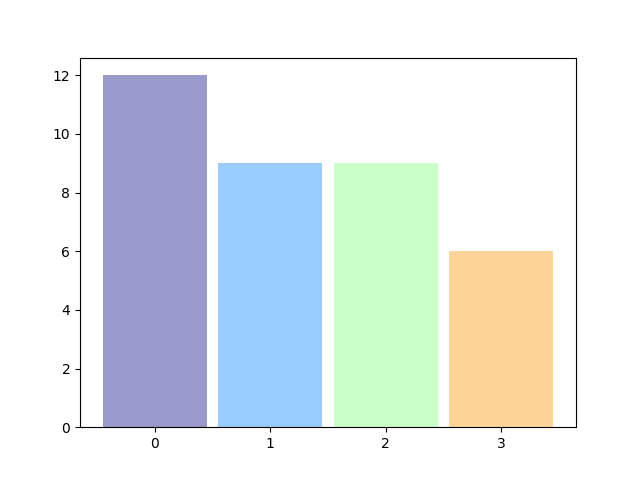

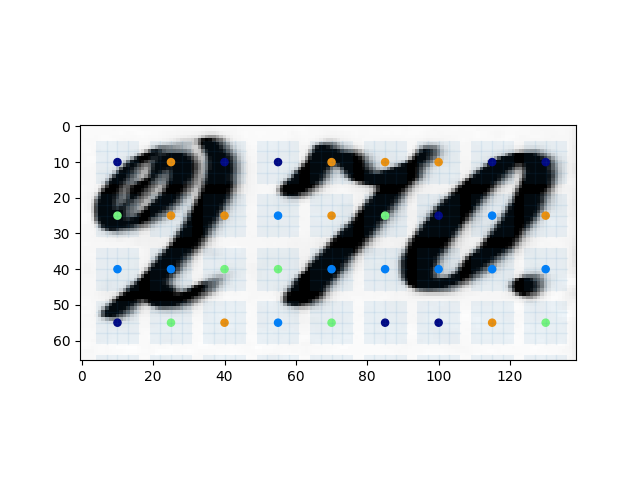

In [89]:

from matplotlib.patches import Circle, Rectangle
from matplotlib.lines import Line2D

draw_descriptor_cells = True
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(np.array(wordImageList[0][0]), cmap=cm.get_cmap('Greys_r'))
ax.autoscale(enable=False)
colormap = cm.get_cmap('jet')
desc_len = cell_size * 4
for (x, y), label in zip(frames, labels):
    color = colormap(label / float(n_centroids))
    circle = Circle((x, y), radius=1, fc=color, ec=color, alpha=1)
    rect = Rectangle((x - desc_len / 2, y - desc_len / 2),
                     desc_len, desc_len, alpha=0.08, lw=1)
    ax.add_patch(circle)
    if draw_descriptor_cells:
        for p_factor in [0.25, 0.5, 0.75]:
            offset_dyn = desc_len * (0.5 - p_factor)
            offset_stat = desc_len * 0.5
            line_h = Line2D((x - offset_stat, x + offset_stat),
                            (y - offset_dyn, y - offset_dyn), alpha=0.08, lw=1)
            line_v = Line2D((x - offset_dyn, x - offset_dyn),
                            (y - offset_stat, y + offset_stat), alpha=0.08, lw=1)
            ax.add_line(line_h)
            ax.add_line(line_v)
    ax.add_patch(rect)




y_values=histograms[0]
x_pos = np.arange(len(y_values))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x_pos, y_values, width=0.9, align='center', alpha=0.4,color=[colormap(i / float(n_centroids)) for i in x_pos])

ax.set_xticks(x_pos)
plt.show()



